In [1]:
import datetime
start_time = datetime.datetime.now()
start_time

datetime.datetime(2022, 4, 24, 9, 48, 32, 88745)

In [2]:
# Also runs installation of dependencies
from lib.util import *

In [3]:
from lib.feature_eng import *

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import dtale
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from prince import MCA
from prince import FAMD

In [5]:
df = read_csv('../dataset/TEDS-D-2019-DS0001-bndl-data-tsv_V1.zip')

## Select Columns

##### Drop Unnecessary

In [6]:
#Unnecessary columns
unnecessarys = ['DISYR','CASEID','CBSA2010','DETCRIM','PREG','DAYWAIT','SERVICES_D','EMPLOY_D','LIVARAG_D','ARRESTS_D',
                     'DETNLF_D','SUB3','SUB3_D','ROUTE3','FREQ3','FREQ3_D','FRSTUSE3','FREQ_ATND_SELF_HELP_D']

#High missing data counts
high_missing = ['DETNLF','PRIMINC','SUB2','SUB2_D','ROUTE2','FREQ2','FREQ1_D','FREQ2_D','FRSTUSE2','HLTHINS','PRIMPAY']

#Drop substance flag columns
substance = ['ALCFLG','COKEFLG', 'MARFLG', 'HERFLG', 'METHFLG', 'OPSYNFLG', 'PCPFLG', 
             'HALLFLG', 'MTHAMFLG', 'AMPHFLG', 'STIMFLG', 'BENZFLG', 'TRNQFLG', 
             'BARBFLG', 'SEDHPFLG', 'INHFLG', 'OTCFLG', 'OTHERFLG']

columns = unnecessarys + high_missing + substance

# Remove columns + NaNs
df_drop = clean_df(df.copy(), columns)

Values dropped: 1029980
States lost: 11


In [7]:
df_drop.head()

,STFIPS,EDUC,MARSTAT,SERVICES,LOS,PSOURCE,NOPRIOR,ARRESTS,EMPLOY,METHUSE,...,SUB1,SUB1_D,ROUTE1,FREQ1,FRSTUSE1,FREQ_ATND_SELF_HELP,DIVISION,REGION,IDU,ALCDRUG
0,2,4.0,1.0,7,37,1.0,0.0,0.0,2.0,2.0,...,2.0,2.0,1.0,2.0,5.0,1.0,9,4,0.0,1
1,2,3.0,1.0,7,35,1.0,0.0,0.0,1.0,2.0,...,2.0,2.0,1.0,2.0,3.0,1.0,9,4,0.0,3
2,2,2.0,1.0,7,35,1.0,0.0,0.0,4.0,2.0,...,2.0,2.0,1.0,2.0,2.0,1.0,9,4,0.0,3
3,2,3.0,1.0,7,37,1.0,1.0,0.0,3.0,2.0,...,2.0,2.0,1.0,1.0,3.0,4.0,9,4,0.0,3
4,2,3.0,3.0,7,37,1.0,1.0,0.0,4.0,2.0,...,2.0,2.0,1.0,1.0,7.0,1.0,9,4,0.0,1


## Feature Engineering

#### Norm Mean of LOS

In [8]:
#Change LOS categories to minimum of range
df_drop.loc[df_drop['LOS'] == 32, 'LOS'] = 46
df_drop.loc[df_drop['LOS'] == 33, 'LOS'] = 61
df_drop.loc[df_drop['LOS'] == 34, 'LOS'] = 91
df_drop.loc[df_drop['LOS'] == 35, 'LOS'] = 121
df_drop.loc[df_drop['LOS'] == 36, 'LOS'] = 181
df_drop.loc[df_drop['LOS'] == 37, 'LOS'] = 366

df_drop = compute_LOS_norm(df_drop)

#### Binary Discharge Status

In [9]:
df_drop.loc[df_drop['REASON'] == 1, 'REASONbinary'] = 1
df_drop.loc[df_drop['REASON'] != 1, 'REASONbinary'] = 0

In [10]:
df_drop.columns

Index(['STFIPS', 'EDUC', 'MARSTAT', 'SERVICES', 'LOS', 'PSOURCE', 'NOPRIOR',
       'ARRESTS', 'EMPLOY', 'METHUSE', 'PSYPROB', 'GENDER', 'VET', 'LIVARAG',
       'REASON', 'DSMCRIT', 'AGE', 'RACE', 'ETHNIC', 'SUB1', 'SUB1_D',
       'ROUTE1', 'FREQ1', 'FRSTUSE1', 'FREQ_ATND_SELF_HELP', 'DIVISION',
       'REGION', 'IDU', 'ALCDRUG', 'LOSnorm', 'REASONbinary'],
      dtype='object')

## Multiple Correspondence Analysis (MCA)

In [11]:
# Make all columns but LOSnorm to strings
df_categories = df_drop.copy()
str_columns = df_drop.columns.drop('LOSnorm')
df_categories[str_columns] = df_categories[str_columns].applymap(str)

In [12]:
features = df_categories.columns.drop('REASONbinary')
mca = MCA(n_components=5, n_iter=3, random_state=101)
model, transformed = unsupervised_model(df_categories, features, mca)

<AxesSubplot:title={'center':'Row and column principal coordinates'}, xlabel='Component 0 (2.66% inertia)', ylabel='Component 1 (2.24% inertia)'>

findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.


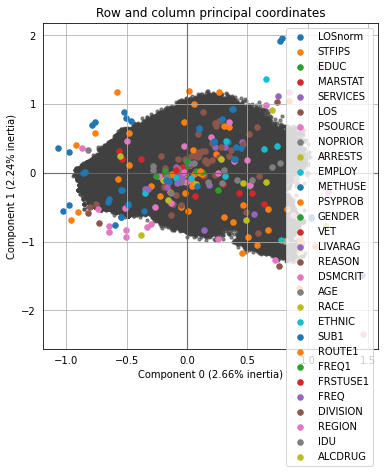

In [13]:
%matplotlib inline

mca.plot_coordinates(X=df_categories[features])

## Factor Analysis of Mixed Data (FAMD)

In [14]:
famd = FAMD(n_components=2, n_iter=3, random_state=101)

features = df_categories.columns.drop('SERVICES')

model, transformed = unsupervised_model(df_categories, features, famd)

<AxesSubplot:title={'center':'Row principal coordinates'}, xlabel='Component 0 (5.86% inertia)', ylabel='Component 1 (2.87% inertia)'>

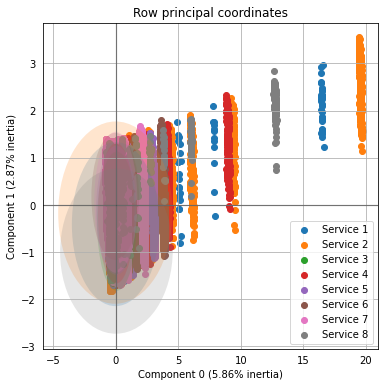

In [15]:
famd.plot_row_coordinates(df_categories,color_labels=[f'Service {t}' for t in df_categories['SERVICES']])

## PCA on Reduced Set with Dummy Variables

In [16]:
columns = ['STFIPS', 'EDUC', 'MARSTAT', 'SERVICES', 'LOS', 'PSOURCE', 'NOPRIOR',
                                   'ARRESTS', 'EMPLOY', 'METHUSE', 'PSYPROB', 'GENDER', 'VET', 'LIVARAG',
                                   'REASON', 'DSMCRIT', 'AGE', 'RACE', 'ETHNIC', 'SUB1', 'SUB1_D',
                                   'ROUTE1', 'FREQ1', 'FRSTUSE1', 'FREQ_ATND_SELF_HELP', 'DIVISION',
                                   'REGION', 'IDU', 'ALCDRUG']

df_dummies = pd.get_dummies(df_drop, prefix=columns, prefix_sep='_', columns=columns)

df_dummies.head()

,LOSnorm,REASONbinary,STFIPS_1,STFIPS_2,STFIPS_5,STFIPS_8,STFIPS_9,STFIPS_10,STFIPS_11,STFIPS_13,...,REGION_0,REGION_1,REGION_2,REGION_3,REGION_4,IDU_0.0,IDU_1.0,ALCDRUG_1,ALCDRUG_2,ALCDRUG_3
0,0.176008,0.0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
1,0.176008,0.0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
2,0.176008,0.0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
3,0.176008,1.0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
4,0.176008,1.0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0


#### Create Dummy Variable DF for Categories

#### Binary Status as Y

In [17]:
columns = df_dummies.columns.drop('REASONbinary')

scaled_df = preprocess(df_dummies, [columns], [StandardScaler()], remainder='drop')

In [18]:
# pca, transformed_X = unsupervised_model(df_dummies, features, PCA(n_components=10))
pca = PCA(n_components=10)
pca.fit(scaled_df)
transformed = pca.transform(scaled_df)

([<matplotlib.axis.XTick at 0x1bc947f88b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

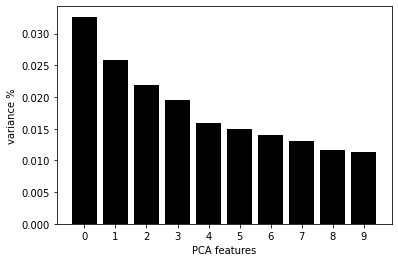

In [19]:
components = range(pca.n_components_)

plt.bar(components, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(components)

Text(0, 0.5, 'PCA 2')

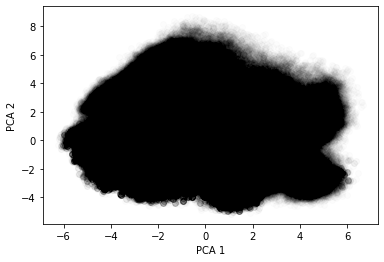

In [20]:
PCA_components_df = pd.DataFrame(transformed)

plt.scatter(PCA_components_df[0], PCA_components_df[1], alpha=.01, color='black') #Alpha reduced to look for clustering
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

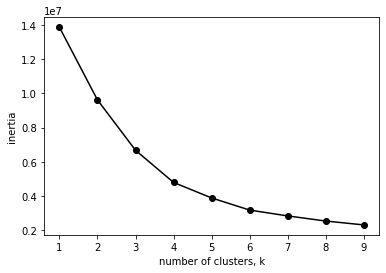

In [21]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components_df.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [22]:
pca = (PCA(n_components=2))

principalComponents = pca.fit_transform(scaled_df)

principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1','PC2'])

finalDf = pd.concat([principalDf, df_drop[['REASONbinary']]], axis=1)

(-7.5, 7.5)

findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.


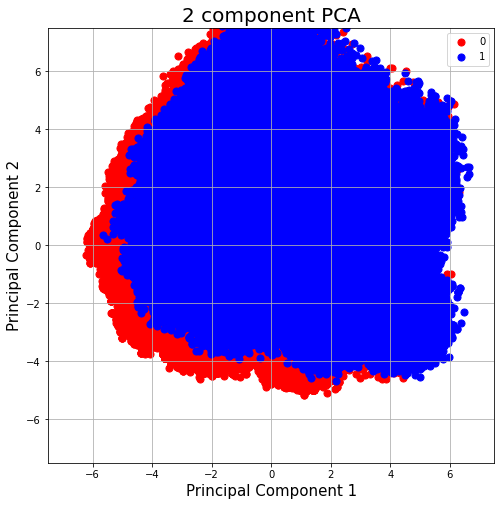

In [23]:
%matplotlib inline

fig = plt.figure(figsize =(8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]

colors = ['r','b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['REASONbinary'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

ax.set_xlim([-7.5,7.5])
ax.set_ylim([-7.5,7.5])

#### LOSnorm as Y

In [24]:
x = df_dummies.loc[:, df_dummies.columns != 'LOSnorm'].values

y = df_dummies.loc[:, ['LOSnorm']].values

x = StandardScaler().fit_transform(x)

([<matplotlib.axis.XTick at 0x1bc92af5e50>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

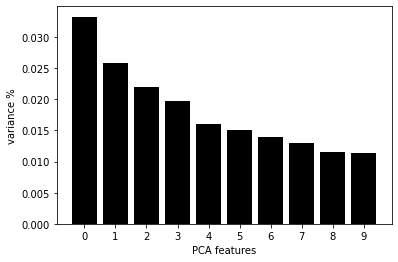

In [25]:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(x)

features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

Text(0, 0.5, 'PCA 2')

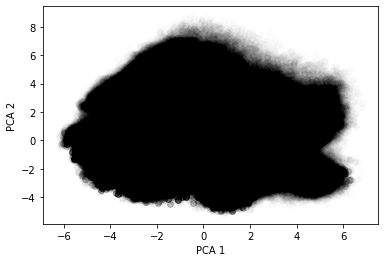

In [26]:
PCA_components_df = pd.DataFrame(principalComponents)

plt.scatter(PCA_components_df[0], PCA_components_df[1], alpha=.01, color='black') #Alpha reduced to look for clustering
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

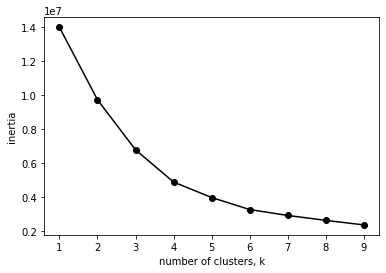

In [27]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components_df.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [28]:
end_time = datetime.datetime.now()
end_time

datetime.datetime(2022, 4, 24, 9, 53, 44, 792954)

In [29]:
# How long it took to run our entire notebook
end_time - start_time

datetime.timedelta(seconds=312, microseconds=704209)